In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/elomia

MessageError: ignored

In [ ]:
import os 
import glob 
import pandas as pd
import numpy as np
import random

In [ ]:
!pip install -U sentence-transformers
!pip install transformers

     |████████████████████████████████| 79 kB 5.8 MB/s 
     |████████████████████████████████| 3.8 MB 33.6 MB/s 
     |████████████████████████████████| 1.2 MB 73.3 MB/s 
     |████████████████████████████████| 67 kB 6.2 MB/s 
     |████████████████████████████████| 895 kB 83.1 MB/s 
     |████████████████████████████████| 596 kB 62.7 MB/s 
     |████████████████████████████████| 6.5 MB 44.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=ca1394e1370141cfa7fc517262a15959aff7aa45cb5652feb7cf7dff334f0352
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text
  
def read_data(base_path):
    dfs = []
    for path in glob.glob(os.path.join(base_path, "*")):
        exercise_df = pd.read_csv(path)

        exercise_df["Ок/Не ок"] = exercise_df["Ок/Не ок"].apply(lambda x: x != "Не ок")

        dfs.append(exercise_df)

    final_df = pd.concat(dfs, ignore_index=True)

    return final_df
    
def get_X_Y_dfs(path, is_one_file):
    if is_one_file is True:
      exercise_df = pd.read_csv(path, on_bad_lines='skip')
    else:
      exercise_df = read_data("data")

    feature_col_name = "Монолог"

    exercise_df[feature_col_name] = exercise_df[feature_col_name].apply(lambda p: clean_text(p))

    phrase_len = exercise_df[feature_col_name].apply(lambda p: len(p.split(' ')))
    max_phrase_len = phrase_len.max()

    return exercise_df, max_phrase_len
    
exercise_df, max_phrase_len = get_X_Y_dfs("data", False) #data

In [ ]:
exercise_df["sentence_trans_embs"] = np.zeros((len(exercise_df),3)).tolist()  # create empty list embs
exercise_df["init_calm_ex_p"] = np.zeros(len(exercise_df))  # model trained on just OK calm exercise
exercise_df["withoutneok_calm_ex_p"] = np.zeros(len(exercise_df))  # model trained on without neOK calm exercise

In [ ]:
exercise_df.head()

,Монолог,Упражнение,Уверенность,Ок/Не ок,Unnamed: 3,sentence_trans_embs,init_calm_ex_p,withoutneok_calm_ex_p
0,i`ve been feeling stressed out . i have been f...,CalmDownExercise,-0.012248,True,NaN,"[0.0, 0.0, 0.0]",0.0,0.0
1,"two birds on a wire . one tries to fly away , ...",CalmDownExercise,-0.378436,False,NaN,"[0.0, 0.0, 0.0]",0.0,0.0
2,"help means more needs than other students , an...",CalmDownExercise,-0.031085,False,NaN,"[0.0, 0.0, 0.0]",0.0,0.0
3,"i`ve been feeling sad , lonely , and anxious ....",CalmDownExercise,-0.624913,False,NaN,"[0.0, 0.0, 0.0]",0.0,0.0
4,i`m usually response to her complaints because...,CalmDownExercise,-0.426002,False,NaN,"[0.0, 0.0, 0.0]",0.0,0.0


In [ ]:
from sentence_transformers import SentenceTransformer, util

sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2') #sentence-transformers/all-mpnet-base-v2

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
model.layers[-1].activation = tf.keras.activations.sigmoid # default - linear
model.load_weights("bert_logs/initial/checkpoints")



withoutneok_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)
withoutneok_model.layers[-1].activation = tf.keras.activations.sigmoid # default - linear
withoutneok_model.load_weights("bert_logs/withoutneok/checkpoints")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for x_item in exercise_df.iterrows():
  index = x_item[0]

  text = x_item[1]["Монолог"]

  embedding = sentence_model.encode(text)

  exercise_df.at[index,'sentence_trans_embs'] = embedding

  tokenized_ex = tokenizer.encode(text,
                                  truncation=True,
                                  padding="max_length",
                                  return_tensors="tf")
  i_preds = model(tokenized_ex)
  w_preds = withoutneok_model(tokenized_ex)

  exercise_df.at[index,'init_calm_ex_p'] = i_preds.logits.numpy()[0][0]
  exercise_df.at[index,'withoutneok_calm_ex_p'] = w_preds.logits.numpy()[0][0]

# Distance measure

In [ ]:
exercise_df.to_csv("result", sep='\t')  #UNCOMMENT IF WANT TO SAVE
# def convert_string_to_np(x):
#     trunc_str_lst = x.replace("[","").replace("]", "").split() # pandas ?:( 
#     return np.array(trunc_str_lst, dtype=np.float32)

# exercise_df = pd.read_csv("result", sep='\t')
# exercise_df['sentence_trans_embs'] = exercise_df['sentence_trans_embs'].apply(lambda x: convert_string_to_np(x))
# exercise_df.head()

In [ ]:
# accuracy check 1
# c_exercise_df["Упражнение"] == "CalmDownExercise") &
len(exercise_df[(exercise_df['Упражнение'] == "CalmDownExercise") & (exercise_df['init_calm_ex_p'] > 0.5 )]) / len(exercise_df)

0.8198473282442749

In [ ]:
# accuracy check 2
just_ok_df = exercise_df[(exercise_df['Ок/Не ок'] == True)]
len(just_ok_df[(just_ok_df['Упражнение'] == "CalmDownExercise") & (just_ok_df['withoutneok_calm_ex_p'] > 0.5 )]) / len(just_ok_df)

0.6652360515021459

# Show nearest

In [ ]:
pd.options.display.max_colwidth = 100

def show_nearest(df, text):
    df["distance"] = np.zeros(len(df))  # model trained on without neOK calm exercise
    # selected_item = df.iloc[ind]
    # selected_item_embs = selected_item["sentence_trans_embs"]
    selected_item_embs = sentence_model.encode(text)

    for index, item in enumerate(df.iterrows()):
        # if index == ind:
        #   continue
        item_embs = item[1]["sentence_trans_embs"]
        distance = util.cos_sim(selected_item_embs, item_embs).numpy()[0][0]
        df.at[item[0],'distance'] = distance

    df.sort_values(by=['distance'], inplace=True, ascending=False)
    return df 


pd.options.display.max_colwidth = 500
test_ind = 22
df = show_nearest(exercise_df, "We are break up")  # <---Enter your text here
df.head(50)

,Монолог,Упражнение,Уверенность,Ок/Не ок,Unnamed: 3,sentence_trans_embs,init_calm_ex_p,withoutneok_calm_ex_p,distance
393,"my relationship with them is pretty close and we can be ourselves around each other . well , we all like watching films , playing sports , working out , playing with nerf guns , video games , jokes and some other stuff . yeah , i wish i could succeed .",CalmDownExercise,-0.039174,False,NaN,"[0.22892697, -0.30983272, 0.3648772, -0.301565, -0.19662297, 0.10868265, -0.03369033, -0.016901666, -0.046022948, 0.12007035, -0.08195189, 0.07233007, -0.18077087, -0.22582772, 0.5815703, 0.044009287, -0.24418987, 0.018284967, -0.25061303, 0.0008838231, -0.7211972, -0.36328292, -0.15481676, 0.20265916, -0.54165506, 0.119155996, -0.110616334, 0.08659186, -0.472997, -0.13452326, 0.12031496, -0.051925868, -0.00720103, -0.2695903, -0.22666782, 0.00082814693, -0.22629339, -0.18219112, -0.25834233...",0.654511,0.546651,0.382028
53,"i have been feeling bad . i feel bad because first the best person ever in my life broke up with me and left me , and won’t even talk to me because i helped them with what they needed and it didn’t go how they wanted it to . i came out to my parents as trans and they don’t accept me and won’t call me by my preferred pronouns and name , and school is so stressful and everything and it’s all making me want to cut and i don’t know how much longer i can keep back the thoughts . i’ve been i have ...",CalmDownExercise,-0.018367,False,NaN,"[0.03943047, -0.14458695, 0.26127213, 0.15072647, -0.011673989, -0.084482074, 0.105198555, 0.059347406, 0.041266285, -0.053629145, 0.01858784, 0.06659638, -0.22396751, -0.18662822, -0.15557891, 0.1678933, -0.26190484, 0.12365925, -0.22355542, 0.21762212, -0.17272836, -0.07947986, -0.18185791, 0.13100097, 0.027658101, 0.47038954, -0.14125603, -0.06565266, -0.07471421, 0.0056003244, 0.23226552, -0.11717927, 0.1312129, -0.048900053, 0.1781984, 0.15071675, -0.14242712, 0.018148908, 0.13586807, -...",0.778073,0.476708,0.364681
450,"i actually have to go now . hi . i feel rather lonely right now and just thinking about things between me and my ex . just kinda , imagining good future scenarios with her where we’re both happy and maybe getting back together . it makes me happy hoping but i know that’s the complete opposite of my current situation and that puts me in a bad mood .",CalmDownExercise,-0.070018,False,NaN,"[0.20915286, -0.25606135, 0.4388719, 0.06383933, 0.11027921, -0.088725306, 0.09161552, 0.03660794, 0.07217306, -0.3020239, 0.10339633, -0.009730472, -0.13363552, -0.22301042, 0.28430346, -0.052556615, -0.04134155, 0.05920404, -0.33635867, 0.14529833, -0.4499684, -0.32861328, -0.058496978, 0.08977653, -0.10349394, 0.3054473, 0.20492655, 0.039006446, -0.17988168, -0.018877804, 0.19225682, 0.033952165, -0.29683995, -0.01286586, -0.09724871, 0.19570714, -0.24149363, 0.070671685, 0.014150781, -0....",0.624175,0.532050,0.355741
111,"when i say i shut everyone out , i mean that when i say i shut everyone out , i don’t really talk to them about my feelings . and i think i do it because i have some trust issues . i don’t have any loved ones . i feel so tired mentally . i’m sorry , i don’t know what to do anymore .",CalmDownExercise,-0.108640,True,NaN,"[0.27525973, -0.03370836, 0.4863992, 0.1761801, 0.15681413, -0.19559264, 0.44674823, 0.35313198, 0.38063285, 0.09524221, -0.38813862, -0.057772487, 0.028174968, -0.24692205, -0.0125657795, 0.17567146, -0.080428585, 0.04508628, -0.31402448, -0.14295779, -0.12681402, 0.15855962, 0.02549345, 0.21786642, -0.053358894, 0.36758485, -0.06277468, -0.059937652, -0.2822651, 0.20172659, -0.3435967, -0.0034701228, 0.057345804, 0.0074365702, 0.061050948, 0.14761055, -0.33069173, 0.06578407, -0.08348418, ...",0.613406,0.521806,0.349922
487,should i try to fight for the relationship if i feel uncertain about feelings of my partner ? but it gives me stress . i feel that if i break up i can feel more calm mentally . but i don’t know what is be

In [ ]:
df[df["Ок/Не ок"] == True].head(100)

,Unnamed: 0,Монолог,Упражнение,Уверенность,Ок/Не ок,Unnamed: 3,sentence_trans_embs,init_calm_ex_p,withoutneok_calm_ex_p,distance
549,549,please . i feel sad . bye .,IncreaseHappinessExercise,NaN,True,NaN,"[0.2576893, -0.04356605, 0.97625226, -0.07060667, -0.03508042, -0.06380645, 0.07310118, 0.4955245, 0.30539638, -0.3251714, -0.21469286, 0.13144466, -0.11616576, -0.25050646, 0.11632357, -0.33580738, -0.07840277, 0.23861758, -0.581366, 0.72147787, -0.6797236, 0.3616249, 0.016106632, 0.21796279, -0.22262776, 0.4163908, 0.20754707, 0.14983799, -0.032161795, 0.026815038, -0.08418022, -0.736868, 0.2896699, -0.13269357, 0.5670365, 0.29660553, -0.17548057, 0.012133208, 0.0820397, -0.00030189753, 0....",0.749549,0.592678,0.370706
504,504,thank you for feeling me free with you . i am feeling good now . with some anxiety . i feel anxious now because i want to have someone sharing my personal .,CalmDownExercise,-0.015386,True,NaN,"[-0.10009286, -0.0435275, 0.33193424, 0.20073333, 0.08163303, 0.11558196, 0.6059087, 0.029986275, 0.06047355, -0.116636716, 0.11799339, 0.019065017, -0.18790369, -0.24339649, 0.07077822, 0.09821979, 0.40611017, 0.005012146, -0.31239474, -0.017715778, -0.7259741, -0.35357514, -0.29757786, -0.026400747, -0.022457281, 0.044943802, 0.0117808925, 0.01135033, 0.110672206, -0.069770984, 0.18420537, -0.27494717, 0.15958126, -0.10968946, 0.19132137, 0.31966123, -0.5340354, 0.16891795, -0.26872262, -0...",0.681889,0.549707,0.328259
88,88,"thank you for trying to help . i’m feeling a bit better .less tense . yes , i want to tell you more about how i feel right now .",CalmDownExercise,-0.043872,True,NaN,"[0.21303852, -0.026293553, 0.57429284, 0.06602697, -0.12230901, -0.0436795, -0.24733247, 0.14034925, 0.112759925, -0.0415495, -0.015386857, 0.2050263, -0.07800691, -0.16018979, 0.10023614, 0.26967424, 0.33287904, 0.18454702, -0.5277917, 0.056801967, -0.5639275, 0.013928761, -0.047121342, 0.35729238, -0.08691671, 0.351901, -0.018017732, 0.23762555, -0.06422571, -0.039981153, -0.21387203, -0.2391436, -0.04754559, -0.12436789, -0.11413753, 0.16327006, -0.14197089, 0.3812435, -0.0053682667, -0.1...",0.704253,0.541104,0.305049
613,613,and i love her . i really do . but she makes me so anxious . and when she take to other guys i get depressed . i have told her how i feel .,CalmDownExercise,NaN,True,NaN,"[0.43125585, -0.2939152, 0.43125945, 0.4543443, -0.13900675, 0.07294565, 0.08447253, 0.3376854, 0.18975477, 0.00600038, -0.4219944, -0.06652051, -0.2787348, -0.6135823, 0.37565684, 0.029999, 0.5687933, -0.17343204, 0.00104191, 0.14416125, -0.35351175, -0.24697891, -0.13149945, 0.18618463, -0.3150771, 0.23787542, -0.18726778, -0.10565283, -0.07888598, 0.22329666, 0.10888218, 0.02913883, 0.16376738, 0.05841817, -0.19857612, 0.14669475, -0.3222094, -0.07288304, -0.22842506, 0.15280783, 0.195039...",0.637239,0.582188,0.299841
204,204,and i love her . i really do . but she makes me so anxious . and when she take to other guys i get depressed . i have told her how i feel .,CalmDownExercise,NaN,True,NaN,"[0.43125585, -0.2939152, 0.43125945, 0.4543443, -0.13900675, 0.07294565, 0.08447253, 0.3376854, 0.18975477, 0.00600038, -0.4219944, -0.06652051, -0.2787348, -0.6135823, 0.37565684, 0.029999, 0.5687933, -0.17343204, 0.00104191, 0.14416125, -0.35351175, -0.24697891, -0.13149945, 0.18618463, -0.3150771, 0.23787542, -0.18726778, -0.10565283, -0.07888598, 0.22329666, 0.10888218, 0.02913883, 0.16376738, 0.05841817, -0.19857612, 0.14669475, -0.3222094, -0.07288304, -0.22842506, 0.15280783, 0.195039...",0.637239,0.582188,0.299841
...,...,...,...,...,...,...,...,...,...,...
96,96,"i`ve been feeling really sad so stressed and can’t live like it . so much can cause stress . yeah , it’s hard for me right now . i know it’s hard .",CalmDownExercise,-0.248512,True,NaN,"[0.11692846, -0.1777611, 0.42539236, 0.2154673, 0.18760945, -0.24290834, -0.11238412, 0.2990617, -0.07356209, -0.1058757, -0.06320678, 0.09243565, -0.12102371, 0.16033784, 0.17092961, 

In [ ]:
df[df["Ок/Не ок"] == False].head(200)

,Монолог,Упражнение,Уверенность,Ок/Не ок,Unnamed: 3,sentence_trans_embs,init_calm_ex_p,withoutneok_calm_ex_p,distance
393,"my relationship with them is pretty close and we can be ourselves around each other . well , we all like watching films , playing sports , working out , playing with nerf guns , video games , jokes and some other stuff . yeah , i wish i could succeed .",CalmDownExercise,-0.039174,False,NaN,"[0.22892697, -0.30983272, 0.3648772, -0.301565, -0.19662297, 0.10868265, -0.03369033, -0.016901666, -0.046022948, 0.12007035, -0.08195189, 0.07233007, -0.18077087, -0.22582772, 0.5815703, 0.044009287, -0.24418987, 0.018284967, -0.25061303, 0.0008838231, -0.7211972, -0.36328292, -0.15481676, 0.20265916, -0.54165506, 0.119155996, -0.110616334, 0.08659186, -0.472997, -0.13452326, 0.12031496, -0.051925868, -0.00720103, -0.2695903, -0.22666782, 0.00082814693, -0.22629339, -0.18219112, -0.25834233...",0.654511,0.546651,0.382028
53,"i have been feeling bad . i feel bad because first the best person ever in my life broke up with me and left me , and won’t even talk to me because i helped them with what they needed and it didn’t go how they wanted it to . i came out to my parents as trans and they don’t accept me and won’t call me by my preferred pronouns and name , and school is so stressful and everything and it’s all making me want to cut and i don’t know how much longer i can keep back the thoughts . i’ve been i have ...",CalmDownExercise,-0.018367,False,NaN,"[0.03943047, -0.14458695, 0.26127213, 0.15072647, -0.011673989, -0.084482074, 0.105198555, 0.059347406, 0.041266285, -0.053629145, 0.01858784, 0.06659638, -0.22396751, -0.18662822, -0.15557891, 0.1678933, -0.26190484, 0.12365925, -0.22355542, 0.21762212, -0.17272836, -0.07947986, -0.18185791, 0.13100097, 0.027658101, 0.47038954, -0.14125603, -0.06565266, -0.07471421, 0.0056003244, 0.23226552, -0.11717927, 0.1312129, -0.048900053, 0.1781984, 0.15071675, -0.14242712, 0.018148908, 0.13586807, -...",0.778073,0.476708,0.364681
450,"i actually have to go now . hi . i feel rather lonely right now and just thinking about things between me and my ex . just kinda , imagining good future scenarios with her where we’re both happy and maybe getting back together . it makes me happy hoping but i know that’s the complete opposite of my current situation and that puts me in a bad mood .",CalmDownExercise,-0.070018,False,NaN,"[0.20915286, -0.25606135, 0.4388719, 0.06383933, 0.11027921, -0.088725306, 0.09161552, 0.03660794, 0.07217306, -0.3020239, 0.10339633, -0.009730472, -0.13363552, -0.22301042, 0.28430346, -0.052556615, -0.04134155, 0.05920404, -0.33635867, 0.14529833, -0.4499684, -0.32861328, -0.058496978, 0.08977653, -0.10349394, 0.3054473, 0.20492655, 0.039006446, -0.17988168, -0.018877804, 0.19225682, 0.033952165, -0.29683995, -0.01286586, -0.09724871, 0.19570714, -0.24149363, 0.070671685, 0.014150781, -0....",0.624175,0.532050,0.355741
81,should i try to fight for the relationship if i feel uncertain about feelings of my partner ? but it gives me stress . i feel that if i break up i can feel more calm mentally . but i don’t know what is best for me . maybe i will be happier in this relationship we just need to work everything out . but on the other hand i am not sure if it is possible,CalmDownExercise,-0.045759,False,NaN,"[0.16364357, -0.075419955, 0.10886553, 0.035363454, 0.106991164, 0.20570828, -0.16634719, 0.021039348, 0.07108575, -0.11535273, 0.11048052, -0.12670644, -0.09206958, -0.19661705, 0.42518714, 0.15047199, 0.14485988, 0.07545781, -0.099454924, 0.21505527, -0.33943486, -0.27562404, -0.22403647, 0.06925194, -0.2051918, 0.28232795, 0.12037123, 0.049828347, 0.027123922, 0.11960906, 0.17840293, -0.29937956, 0.06916011, -0.14776227, 0.0012732259, -0.099690564, -0.28063437, -0.11865364, 0.09740962, -0...",0.561903,0.456626,0.349087
390,"i`ve been feeling very tired . yes , i would like to talk about something . i hang onto a lot of negative emotions and no one will liste

In [ ]:
!pip install umap-learn
!pip install hdbscan 

     |████████████████████████████████| 5.2 MB 7.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330774 sha256=6a6c72d9a94dad55e50e11de43a7a9d1914b2f2463f739231675baec120c3938
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan


In [ ]:
### ?
embeddings = []

for item in exercise_df["sentence_trans_embs"].values:
  embeddings.append(item)
### 

import umap
import matplotlib.pyplot as plt

import hdbscan


# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])

cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_data)

result['labels'] = cluster.labels_

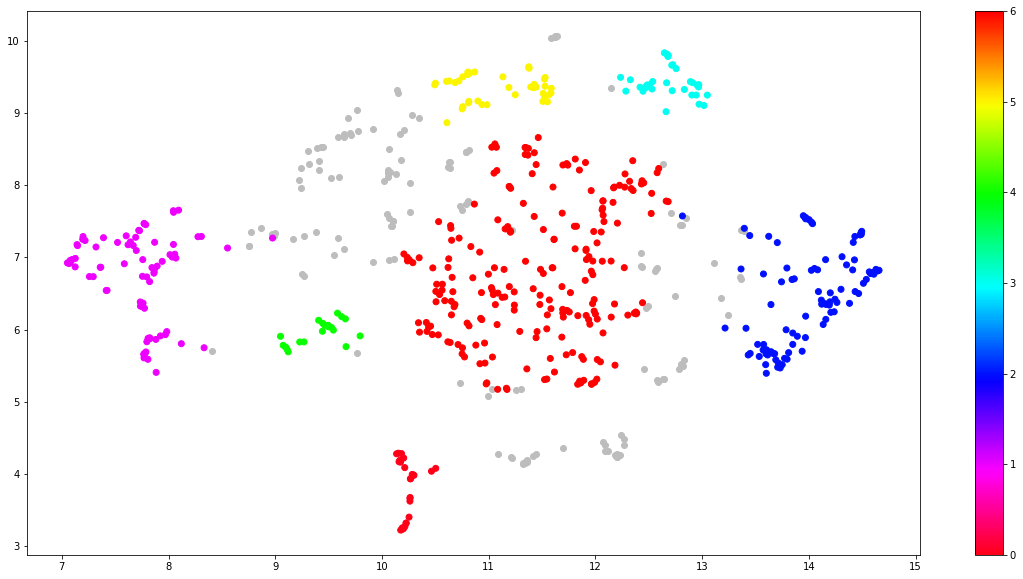

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD')
plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r')
plt.colorbar()

In [ ]:
### ?
embeddings = []

for item in exercise_df["sentence_trans_embs"].values:
  embeddings.append(item)
### 

# Convert NumPy array of embedding into data frame
embedding_df = pd.DataFrame(np.array(embeddings))

# Save dataframe as as TSV file without any index and header
embedding_df.to_csv('embeddings.tsv', sep='\t', index=None, header=None)


In [ ]:
exercise_df[["Монолог","Упражнение"]].to_csv('metadata2.tsv', sep='\t', index=None, header=["text", "label"])

In [ ]:
len(exercise_df[["Монолог","Упражнение"]])

655

In [ ]:
pd.set_option('display.max_rows', 700)
exercise_df[["Монолог","Упражнение"]].head(1000)

,Монолог,Упражнение
0,i`ve been feeling stressed out . i have been f...,True
1,"two birds on a wire . one tries to fly away , ...",True
2,"help means more needs than other students , an...",True
3,"i`ve been feeling sad , lonely , and anxious ....",True
4,i`m usually response to her complaints because...,True
5,i feel like i’m so full of people at work sinc...,True
6,i’ve only had this vacation planned for a coup...,True
7,the most worrying thing is having my blood lea...,True
8,i am on my time of the month . i think i feel ...,True
9,i have been feeling stressed . moving house is...,True
